In [1]:
#Modules for executing steps of Notebook
import acquire
import explore

In [2]:
#Plotting libraries
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
from pylab import rcParams

#Style-settings for Notebook
rcParams['figure.figsize'] = 18, 8
plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

In [3]:
#Statistic tools for plots and for scoring
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

## ACQUIRE/PREP

Acquire the data from the online source at https://ds.codeup.com/fitbit-data.tar.gz

In [5]:
df = acquire.get_data()

In [6]:
len(df)

225

In [7]:
df.Date.nunique()

225

Df2 is the prepared data, with no nulls and with all dtypes are numerical

In [8]:
df2 = acquire.clean_data(df)

In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2018-04-26 to 2018-12-06
Data columns (total 9 columns):
Calories Burned           225 non-null float64
Steps                     225 non-null float64
Distance                  225 non-null float64
Floors                    225 non-null int64
Minutes Sedentary         225 non-null float64
Minutes Lightly Active    225 non-null int64
Minutes Fairly Active     225 non-null int64
Minutes Very Active       225 non-null int64
Activity Calories         225 non-null float64
dtypes: float64(5), int64(4)
memory usage: 17.6 KB


Scaled DataFrame if need be

In [9]:
scaled_df = acquire.scale_data(df2)
scaled_df = scaled_df.set_index(df2.index)

# EXPLORE

#### Bird's Eye View of the Dataset

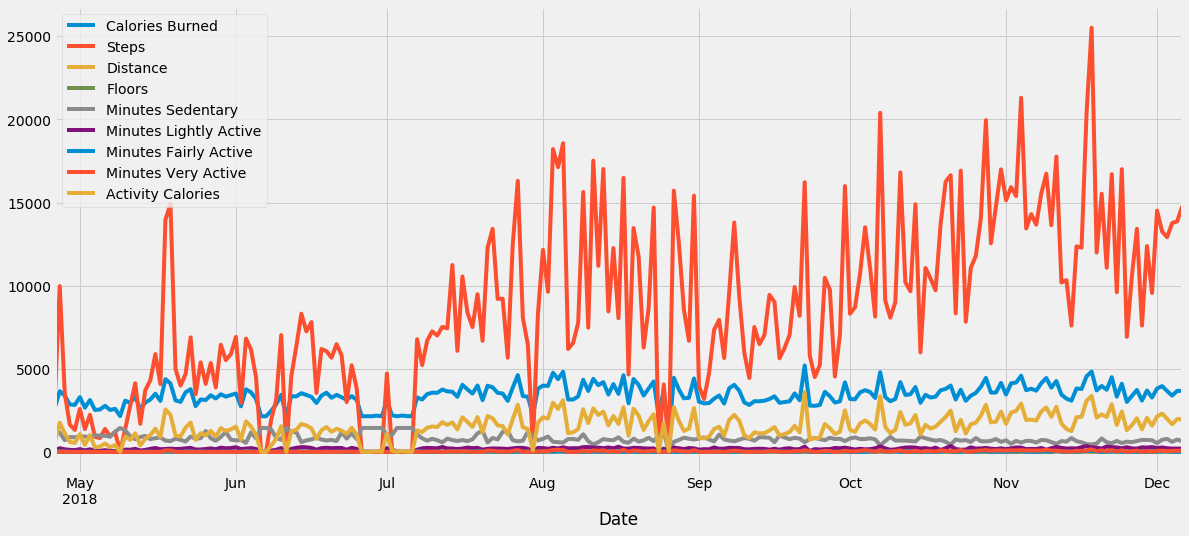

In [10]:
df2.plot()
plt.show()

#### Bird's Eye View of the Dataset, without Steps column

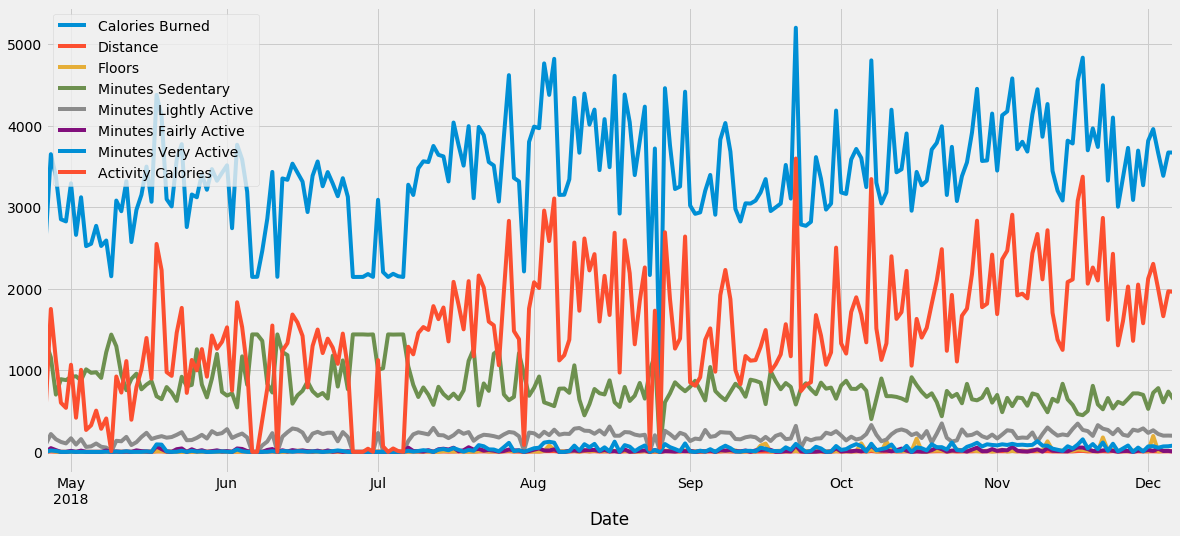

In [11]:
df2.drop('Steps',axis=1).plot()
plt.show()

#### Bird's Eye View of the Dataset

#### With scaled data

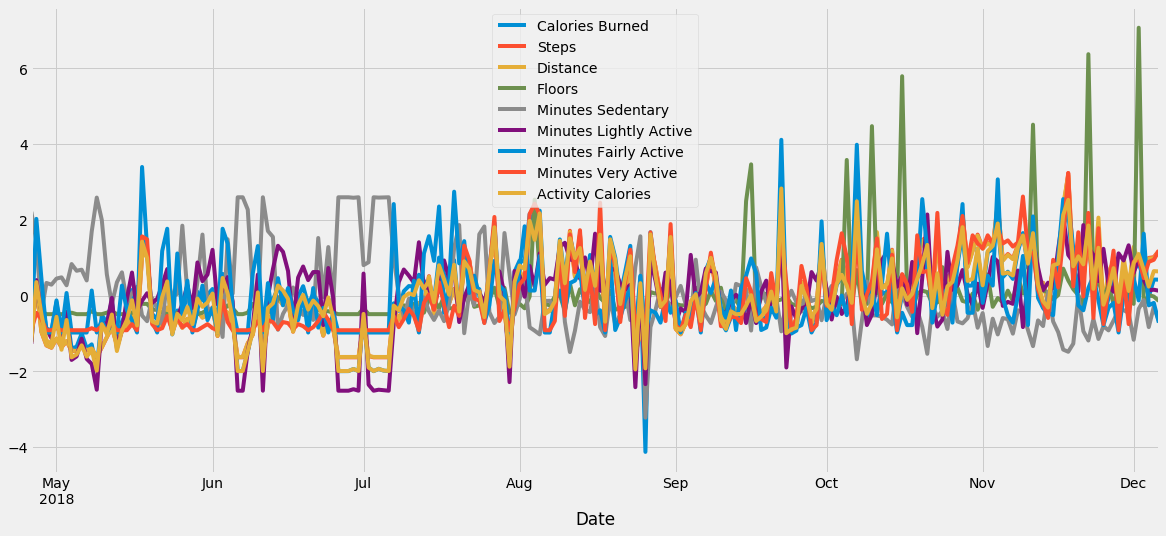

In [15]:
scaled_df.plot()
plt.show()

### The day of the EVENT

In [13]:
date_of_event = '2018-07-01'

In [14]:
event_range = scaled_df['2018-05':'2018-08']

2 months before and after The Event

Trends for Steps and Sedentary Minutes reverse

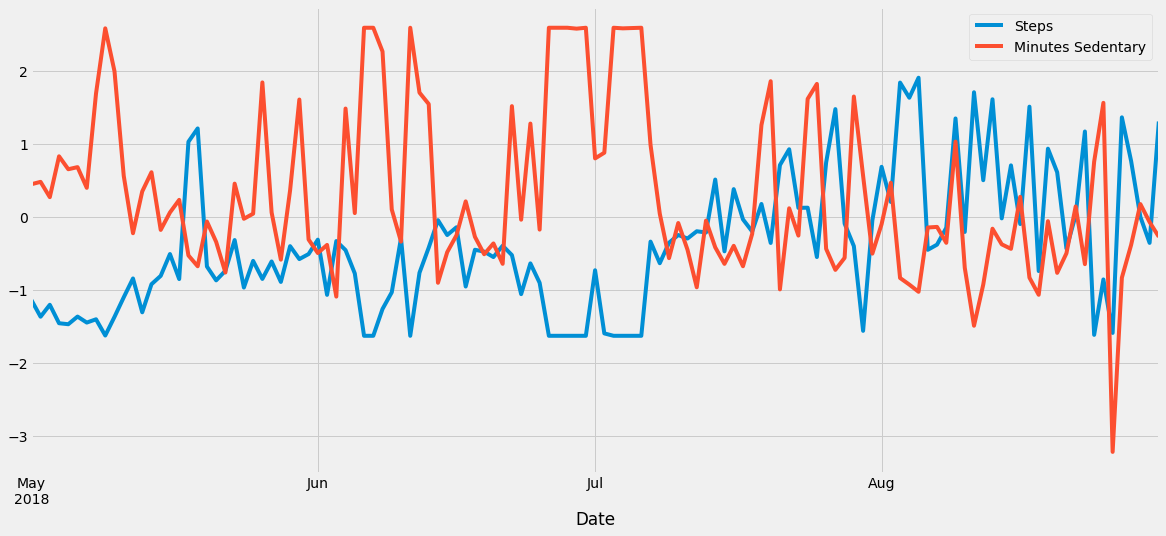

In [17]:
event_range[['Steps','Minutes Sedentary']].plot()
plt.show()

In [18]:
#Splitting the time into before and after the speculated event
pre_event = df2[:date_of_event]
post_event = df2[date_of_event:]

In [19]:
#This will be for testing/plotting purposes in a later section
pre_event_with_room = df2[:'2018-08-01']

## Before the event

In [20]:
pre_event.describe()

,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
count,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000
mean,3047.820896,4064.955224,1.917164,2.492537,962.880597,152.134328,10.895522,6.223881,954.597015
std,510.418899,3067.709329,1.446857,3.726942,268.292949,82.320677,14.360230,15.878154,581.841332
min,2144.000000,0.000000,0.000000,0.000000,545.000000,0.000000,0.000000,0.000000,0.000000
25%,2701.000000,1511.000000,0.710000,0.000000,746.500000,98.000000,0.000000,0.000000,523.000000
50%,3127.000000,3989.000000,1.880000,1.000000,891.000000,171.000000,5.000000,1.000000,1011.000000
75%,3396.000000,5880.500000,2.770000,3.000000,1182.500000,221.500000,18.000000,6.500000,1368.500000
max,4376.000000,14917.000000,7.040000,19.000000,1440.000000,287.000000,67.000000,92.000000,2549.000000


## After the event

In [21]:
post_event.describe()

,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,3549.157233,10396.251572,4.932704,16.792453,746.125786,203.723270,16.522013,45.308176,1705.597484
std,619.546971,4833.587821,2.310583,29.674623,200.078711,66.318746,15.506567,37.518763,695.647118
min,799.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000
25%,3157.000000,7038.500000,3.320000,6.000000,634.000000,172.000000,6.000000,11.000000,1276.500000
50%,3553.000000,9719.000000,4.580000,9.000000,716.000000,210.000000,13.000000,42.000000,1684.000000
75%,3936.000000,13780.500000,6.595000,16.000000,816.000000,242.500000,22.500000,76.500000,2114.500000
max,5199.000000,25512.000000,12.000000,195.000000,1440.000000,349.000000,78.000000,154.000000,3596.000000


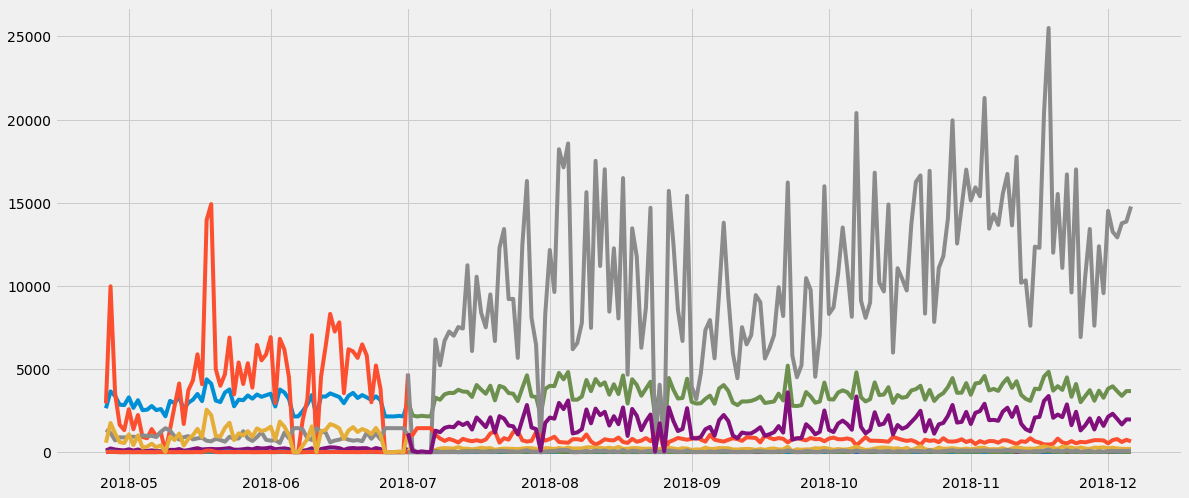

In [22]:
plt.plot(pre_event)
plt.plot(post_event)
plt.show()

    Why the outlier spikes in floors column?

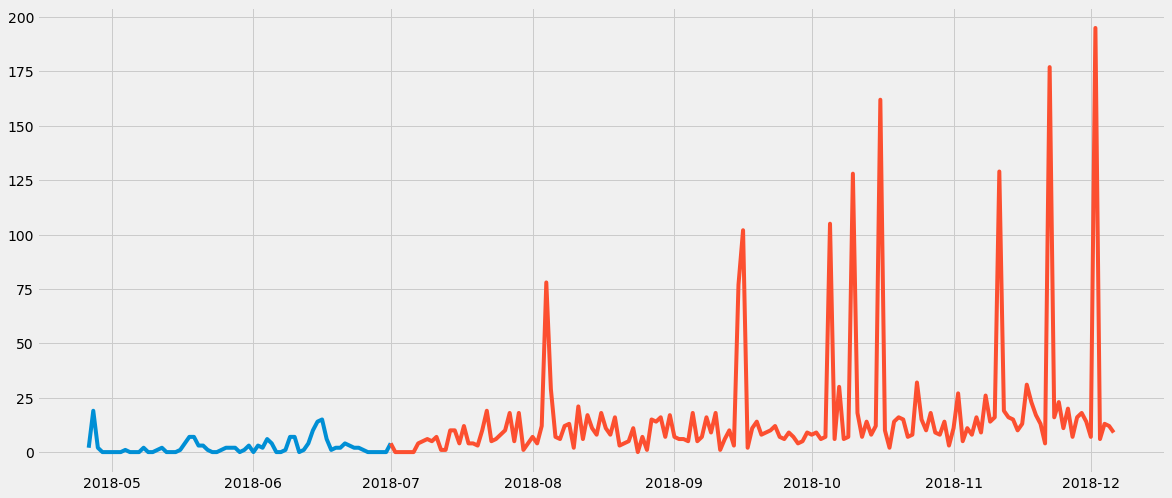

In [24]:
plt.plot(pre_event.Floors)
plt.plot(post_event.Floors)
plt.show()

    Activty Calories is much greater after The Event

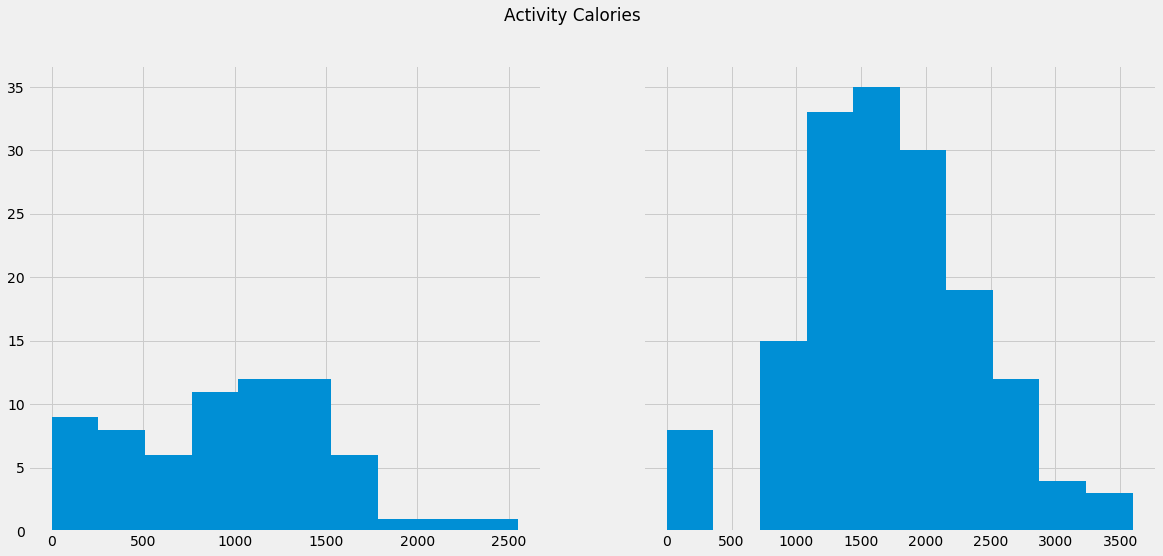

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey='row')
fig.suptitle('Activity Calories')
ax1.hist(pre_event['Activity Calories'])
ax2.hist(post_event['Activity Calories'])
plt.show()

## Decomposition
### Are trends consitent throughout the timeline?

In [32]:
#The steps is very out of range from the rest of the columns. It's dropped for visual purposes.
all_time = seasonal_decompose(df2.drop('Steps',axis=1), model='additive')

    There looks to be a change in the trend starting at the end of June

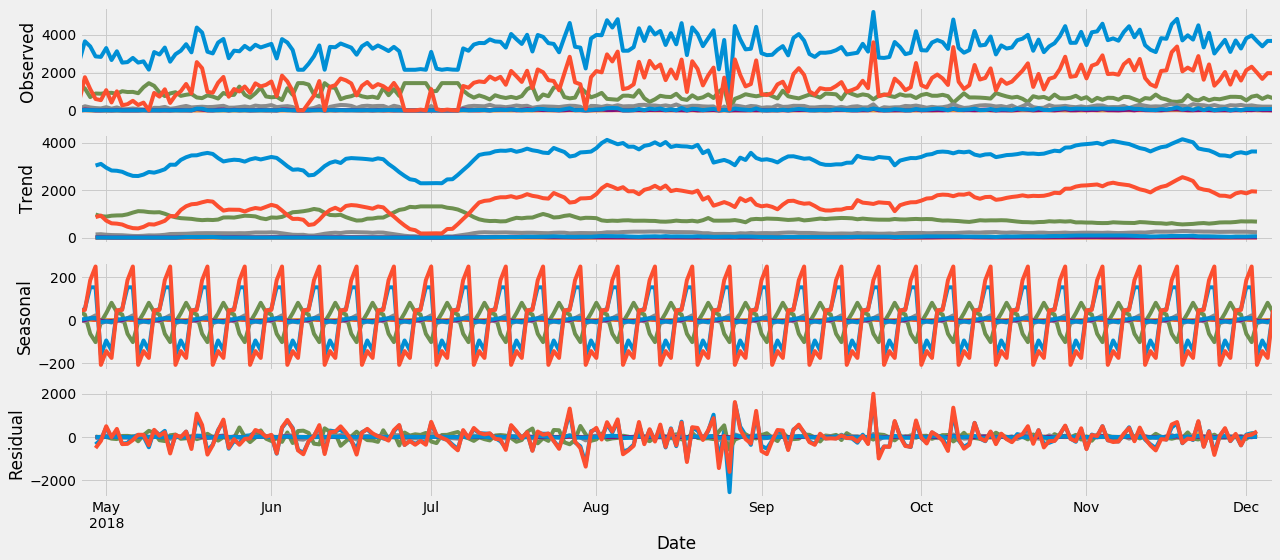

In [33]:
all_time.plot()
plt.show()

    Steps has a demonstrable change in trend after The Event

In [34]:
just_steps = seasonal_decompose(df2.Steps, model='additive')

In [35]:
sedentary = seasonal_decompose(df2['Minutes Sedentary'], model='additive')

    Steps really exploded after The Event at July 1

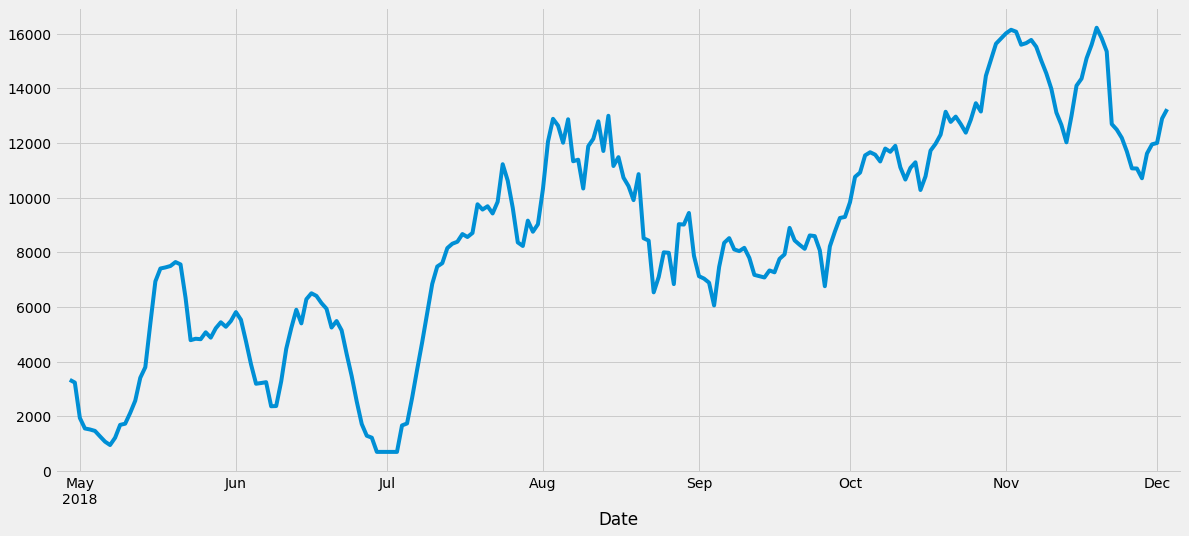

In [36]:
just_steps.trend.plot()
plt.show()

    Sedentary time is trending down and has much lower mean after The Event

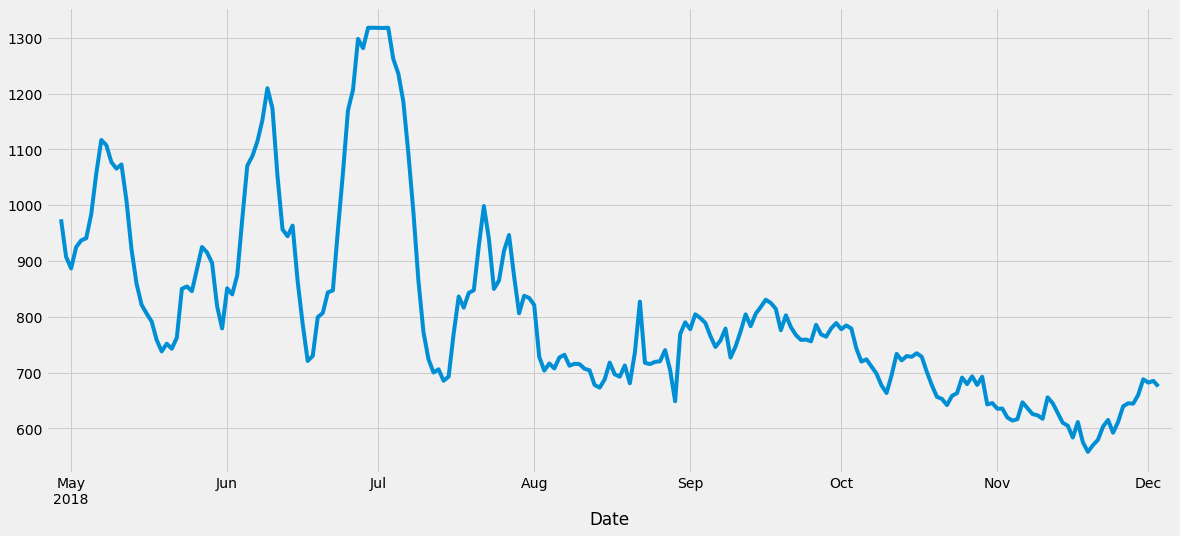

In [37]:
sedentary.trend.plot()
plt.show()

Pre-Event

    There is not much change in seasonlity effects or amount of noise before and after The Event.

In [39]:
result = seasonal_decompose(pre_event.drop('Steps',axis=1), model='additive')

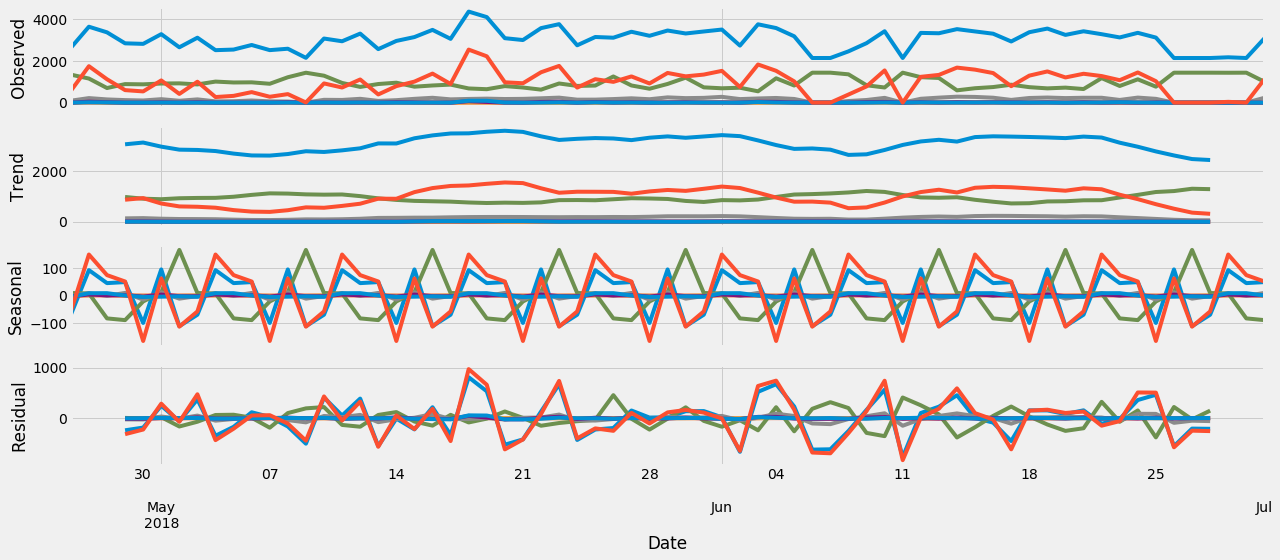

In [40]:
result.plot()
plt.show()

Post-Event

    The mean of most columns increase and their variance decreases.

In [41]:
result2 = seasonal_decompose(post_event.drop('Steps',axis=1), model='additive')

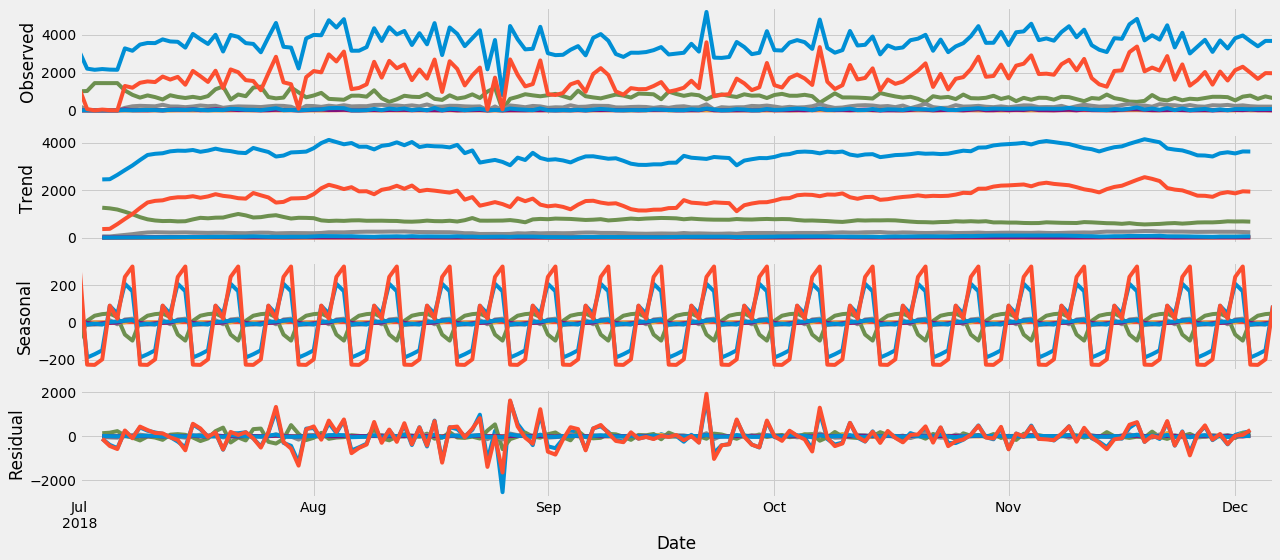

In [42]:
result2.plot()
plt.show()

# FORECASTING

### ARIMA model
#### Predicting the 4 Weeks After the End of the Dataset, using all of the dataset
    Activity Calories

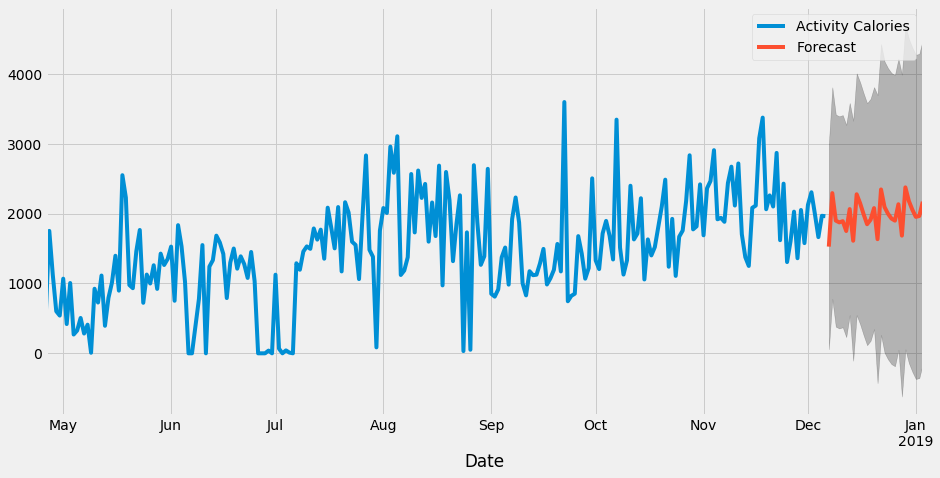

In [43]:
explore.time_predict(df2,'Activity Calories',forecast=True, step_count=28)
plt.show()

In [44]:
explore.time_predict(df2,'Activity Calories',stats_info=True, step_count=28)

<<<<<>>>>><|_STATS_INFO_|><<<<<>>>>>
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2485      0.065      3.806      0.000       0.121       0.376
ma.L1         -1.0000      0.086    -11.603      0.000      -1.169      -0.831
ar.S.L7       -0.4596      0.052     -8.817      0.000      -0.562      -0.357
sigma2      5.585e+05   1.54e-07   3.62e+12      0.000    5.59e+05    5.59e+05


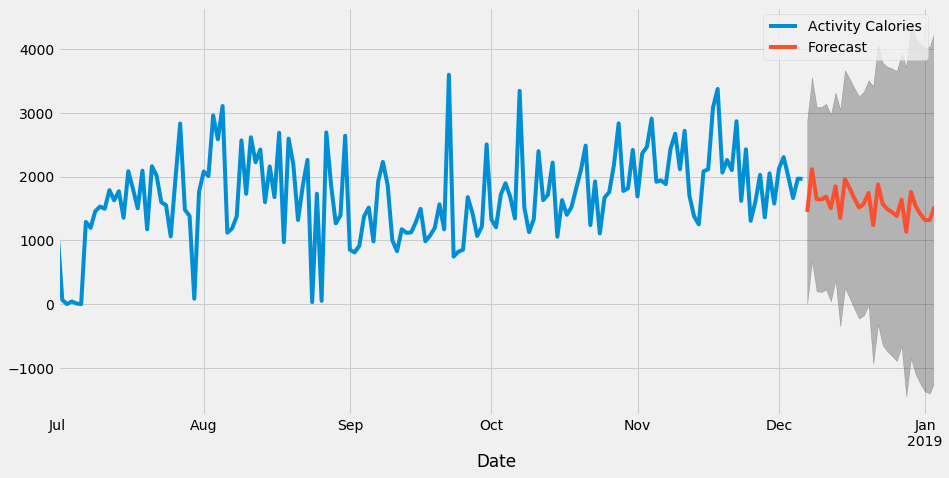

In [45]:
explore.time_predict(post_event,'Activity Calories',forecast=True, step_count=28)
plt.show()

In [46]:
explore.time_predict(post_event,'Activity Calories',stats_info=True, step_count=28)

<<<<<>>>>><|_STATS_INFO_|><<<<<>>>>>
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0235      0.098     -0.240      0.810      -0.215       0.168
ma.L1         -0.9057      0.041    -21.971      0.000      -0.986      -0.825
ar.S.L7       -0.4996      0.060     -8.310      0.000      -0.617      -0.382
sigma2       5.36e+05   5.36e+04     10.000      0.000    4.31e+05    6.41e+05


    Calories Burned

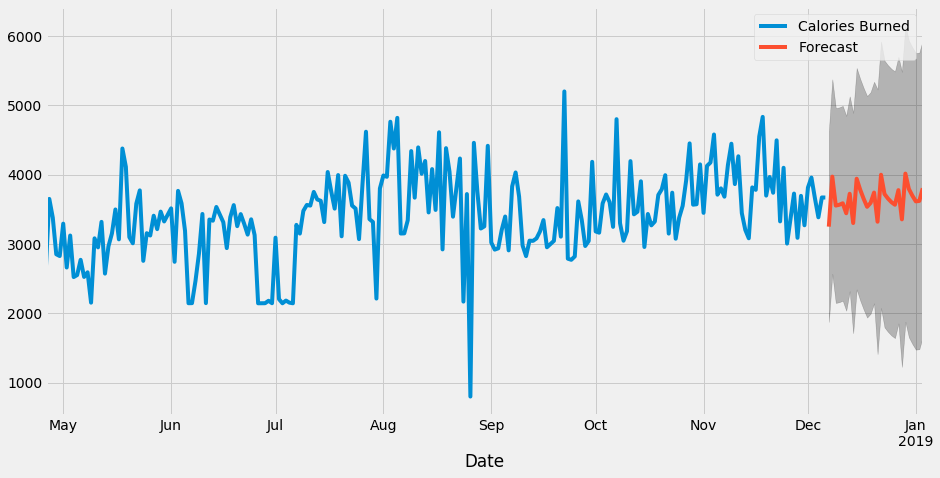

In [47]:
explore.time_predict(df2,'Calories Burned',forecast=True, step_count=28)
plt.show()

In [48]:
explore.time_predict(df2,'Calories Burned',stats_info=True, step_count=28)

<<<<<>>>>><|_STATS_INFO_|><<<<<>>>>>
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2022      0.065      3.106      0.002       0.075       0.330
ma.L1         -1.0000      0.066    -15.123      0.000      -1.130      -0.870
ar.S.L7       -0.4655      0.054     -8.633      0.000      -0.571      -0.360
sigma2      4.891e+05   1.35e-07   3.62e+12      0.000    4.89e+05    4.89e+05


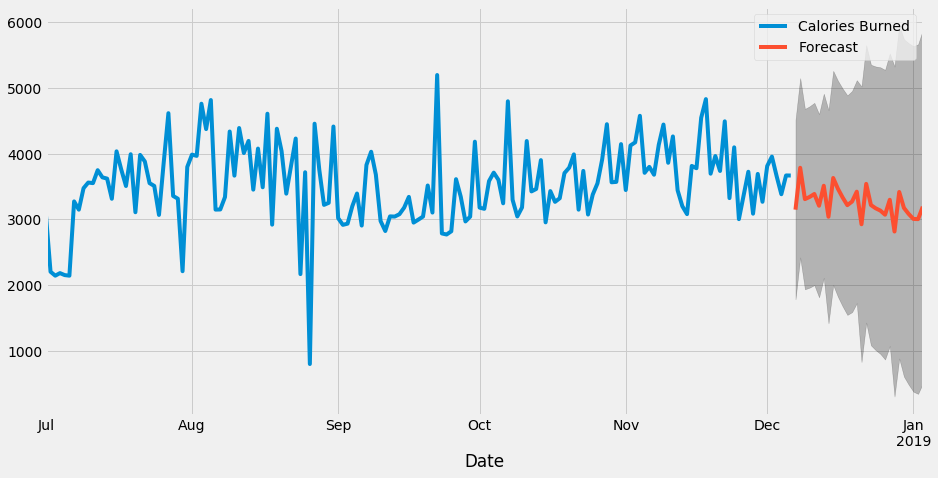

In [49]:
explore.time_predict(post_event,'Calories Burned',forecast=True, step_count=28)
plt.show()

In [50]:
explore.time_predict(post_event,'Calories Burned',stats_info=True, step_count=28)

<<<<<>>>>><|_STATS_INFO_|><<<<<>>>>>
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0773      0.105     -0.738      0.461      -0.283       0.128
ma.L1         -0.8895      0.046    -19.129      0.000      -0.981      -0.798
ar.S.L7       -0.5034      0.058     -8.754      0.000      -0.616      -0.391
sigma2      4.848e+05   4.26e+04     11.393      0.000    4.01e+05    5.68e+05


#### Predicting the 2 Weeks After the Event

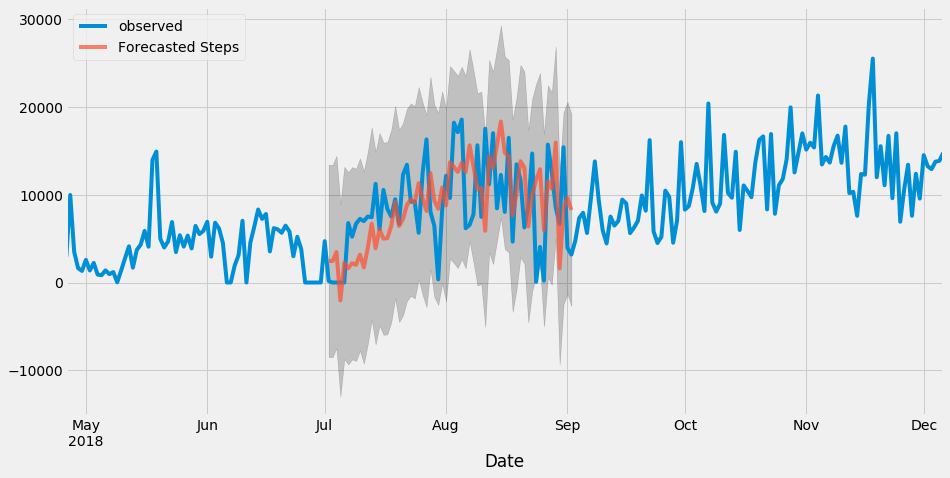

In [9]:
explore.show_bad_predictions(df2, 'Steps')

# Conclusions

    Trends for several columns shifted upward after a negative spike around 01JUL2018
    
    The mean for several columns increased afte the spike
    
    Floors Columns had some very exorbitant outliers after this spike